# Do emissions-based temperature attribution using fair

- Calibration set v1.5.0 (historical observed to 2023)
- Emissions scenario CMIP7 preliminary historical extended with re-harmonized SSP2-4.5 (to 2024)

In [1]:
import os

from fair import FAIR
from fair.interface import fill, initialise
from fair.io import read_properties
import matplotlib.pyplot as pl
import numpy as np
import pandas as pd
import scipy.stats
import xarray as xr

/Users/bensan/Documents/Github/emissions-attribution/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pl.style.use('../defaults.mplstyle')

In [3]:
scenarios = ['ssp245', 'ssp245-noCH4', 'ssp245-noSO2']

In [4]:
f = FAIR()
f.define_time(1750, 2025, 1)
f.define_scenarios(scenarios)
species, properties = read_properties('../data/calibration/species_configs_properties_1.5.0.csv')
f.define_species(species, properties)
f.ch4_method='Thornhill2021'
df_configs = pd.read_csv('../data/calibration/calibrated_constrained_parameters_1.5.0.csv', index_col=0)
f.define_configs(df_configs.index)
f.allocate()

In [5]:
f.fill_from_csv(
    emissions_file='../data/emissions/ssp245_2022_harmon_1750-2024.csv',
    forcing_file='../data/forcing/volcanic_solar.csv',
)

In [6]:
fill(
    f.forcing,
    f.forcing.sel(specie="Volcanic") * df_configs["forcing_scale[Volcanic]"].values.squeeze(),
    specie="Volcanic",
)
fill(
    f.forcing,
    f.forcing.sel(specie="Solar") * df_configs["forcing_scale[Solar]"].values.squeeze(),
    specie="Solar",
)

f.fill_species_configs("../data/calibration/species_configs_properties_1.5.0.csv")
f.override_defaults("../data/calibration/calibrated_constrained_parameters_1.5.0.csv")

# initial conditions
initialise(f.concentration, f.species_configs["baseline_concentration"])
initialise(f.forcing, 0)
initialise(f.temperature, 0)
initialise(f.cumulative_emissions, 0)
initialise(f.airborne_emissions, 0)

In [7]:
f.run()

Running 2523 projections in parallel: 100%|██████████| 275/275 [00:07<00:00, 35.10timesteps/s]


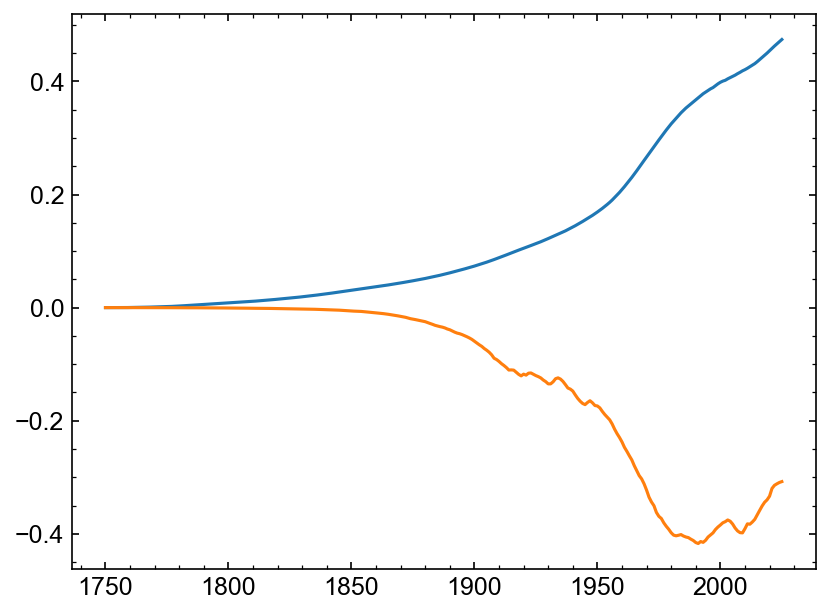

In [8]:
mnr=(
        (f.temperature.sel(layer=0, scenario='ssp245-noSO2'))
    ).median(dim='config')

dch4=(
        (f.temperature.sel(layer=0, scenario='ssp245')) - 
        (f.temperature.sel(layer=0, scenario='ssp245-noCH4'))
    ).median(dim='config')

dso2=(
        (f.temperature.sel(layer=0, scenario='ssp245')) - 
        (f.temperature.sel(layer=0, scenario='ssp245-noSO2'))
    ).median(dim='config')

pl.plot(
    f.timebounds,
    dch4
)
pl.plot(
    f.timebounds,
    dso2
)

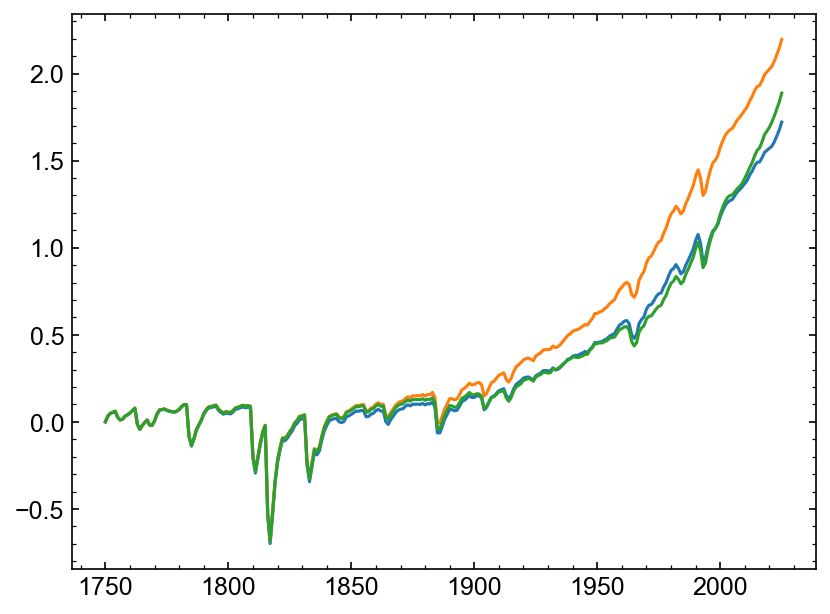

In [9]:

pl.plot(
    f.timebounds,
    mnr
)
pl.plot(
    f.timebounds,
    mnr+dch4
)
pl.plot(
    f.timebounds,
    mnr+dch4+dso2
)

In [10]:
f_noco2 = FAIR()
f_noco2.define_time(1750, 2025, 1)
f_noco2.define_scenarios(['ssp245', 'ssp245-noCO2', 'ssp245-noGHG'])
species, properties = read_properties('../data/calibration/species_configs_properties_1.5.0_noCO2.csv')
f_noco2.define_species(species, properties)
f_noco2.ch4_method='Thornhill2021'
df_configs = pd.read_csv('../data/calibration/calibrated_constrained_parameters_1.5.0.csv', index_col=0)
f_noco2.define_configs(df_configs.index)
f_noco2.allocate()

f_noco2.fill_from_csv(
    emissions_file='../data/emissions/ssp245_2022_harmon_1750-2024.csv',
    forcing_file='../data/forcing/external_forcing_noCO2.csv',
)

fill(
    f_noco2.forcing,
    f_noco2.forcing.sel(specie="Volcanic") * df_configs["forcing_scale[Volcanic]"].values.squeeze(),
    specie="Volcanic",
)
fill(
    f_noco2.forcing,
    f_noco2.forcing.sel(specie="Solar") * df_configs["forcing_scale[Solar]"].values.squeeze(),
    specie="Solar",
)
fill(
    f_noco2.forcing,
    f_noco2.forcing.sel(specie="Land use") * df_configs["forcing_scale[Land use]"].values.squeeze(),
    specie="Land use",
)

f_noco2.fill_species_configs("../data/calibration/species_configs_properties_1.5.0_noCO2.csv")
f_noco2.override_defaults("../data/calibration/calibrated_constrained_parameters_1.5.0.csv")

# initial conditions
initialise(f_noco2.concentration, f_noco2.species_configs["baseline_concentration"])
initialise(f_noco2.forcing, 0)
initialise(f_noco2.temperature, 0)
initialise(f_noco2.cumulative_emissions, 0)
initialise(f_noco2.airborne_emissions, 0)

f_noco2.run()

Running 2523 projections in parallel: 100%|██████████| 275/275 [00:07<00:00, 37.36timesteps/s]


In [15]:
f_noco2_1990 = FAIR()
f_noco2_1990.define_time(1750, 2025, 1)
f_noco2_1990.define_scenarios(['ssp245', 'ssp245-noCO2', 'ssp245-noGHG', ])
species, properties = read_properties('../data/calibration/species_configs_properties_1.5.0_noCO2.csv')
f_noco2_1990.define_species(species, properties)
f_noco2_1990.ch4_method='Thornhill2021'
df_configs = pd.read_csv('../data/calibration/calibrated_constrained_parameters_1.5.0.csv', index_col=0)
f_noco2_1990.define_configs(df_configs.index)
f_noco2_1990.allocate()

f_noco2_1990.fill_from_csv(
    emissions_file='../data/emissions/ssp245_2022_hold1990_1750-2024.csv',
    forcing_file='../data/forcing/external_forcing_noCO2.csv'
)

fill(
    f_noco2_1990.forcing,
    f_noco2_1990.forcing.sel(specie="Volcanic") * df_configs["forcing_scale[Volcanic]"].values.squeeze(),
    specie="Volcanic",
)
fill(
    f_noco2_1990.forcing,
    f_noco2_1990.forcing.sel(specie="Solar") * df_configs["forcing_scale[Solar]"].values.squeeze(),
    specie="Solar",
)
fill(
    f_noco2_1990.forcing,
    f_noco2_1990.forcing.sel(specie="Land use") * df_configs["forcing_scale[Land use]"].values.squeeze(),
    specie="Land use",
)

f_noco2_1990.fill_species_configs("../data/calibration/species_configs_properties_1.5.0_noCO2.csv")
f_noco2_1990.override_defaults("../data/calibration/calibrated_constrained_parameters_1.5.0.csv")

# initial conditions
initialise(f_noco2_1990.concentration, f_noco2.species_configs["baseline_concentration"])
initialise(f_noco2_1990.forcing, 0)
initialise(f_noco2_1990.temperature, 0)
initialise(f_noco2_1990.cumulative_emissions, 0)
initialise(f_noco2_1990.airborne_emissions, 0)

f_noco2_1990.run()

Running 2523 projections in parallel: 100%|██████████| 275/275 [00:07<00:00, 36.80timesteps/s]


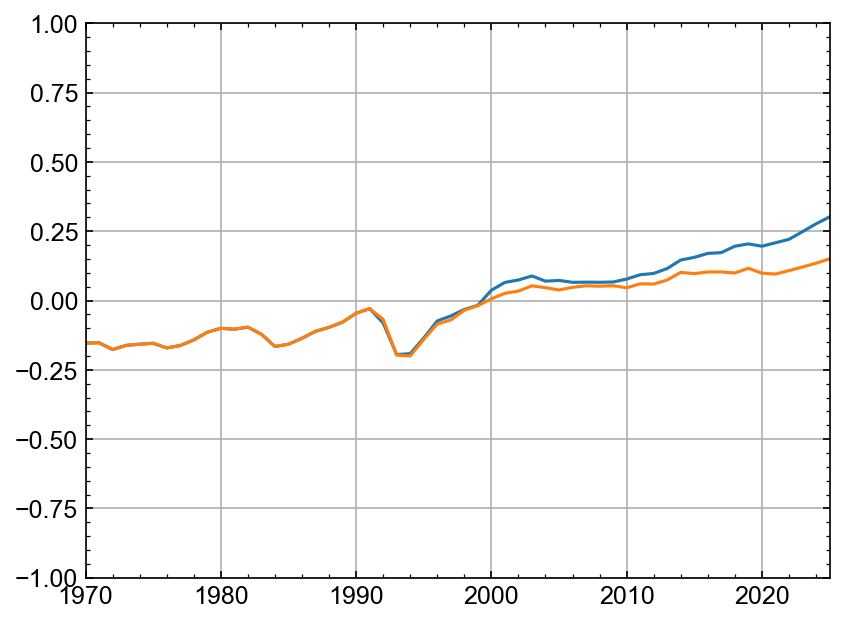

In [84]:
nco2r=(((f_noco2.temperature.sel(layer=0, scenario='ssp245-noCO2')))).median(dim='config')

nco2r_1990=((f_noco2_1990.temperature.sel(layer=0, scenario='ssp245-noCO2'))).median(dim='config')

nco2f=(((f_noco2.forcing_sum.sel(scenario='ssp245-noCO2')))).median(dim='config')

nco2f_1990=((f_noco2_1990.forcing_sum.sel(scenario='ssp245-noCO2'))).median(dim='config')
pl.plot(
    f_noco2.timebounds,
    nco2r
)
pl.plot(
    f_noco2.timebounds,
    nco2r_1990
)


pl.ylim(-1,1)
pl.xlim(1970,2025)

pl.grid()

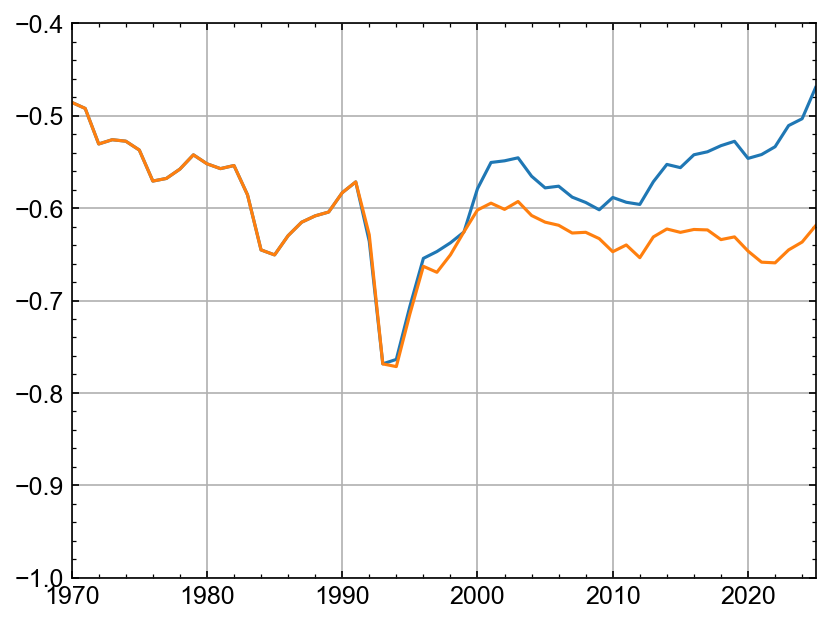

In [85]:
nghgr=(((f_noco2.temperature.sel(layer=0, scenario='ssp245-noGHG')))).median(dim='config')

nghgr_1990=((f_noco2_1990.temperature.sel(layer=0, scenario='ssp245-noGHG'))).median(dim='config')

nghgf=(((f_noco2.forcing_sum.sel( scenario='ssp245-noGHG')))).median(dim='config')

nghgf_1990=((f_noco2_1990.forcing_sum.sel(scenario='ssp245-noGHG'))).median(dim='config')
pl.plot(
    f_noco2.timebounds,
    nghgr
)
pl.plot(
    f_noco2.timebounds,
    nghgr_1990
)


pl.ylim(-1,-.4)
pl.xlim(1970,2025)

pl.grid()

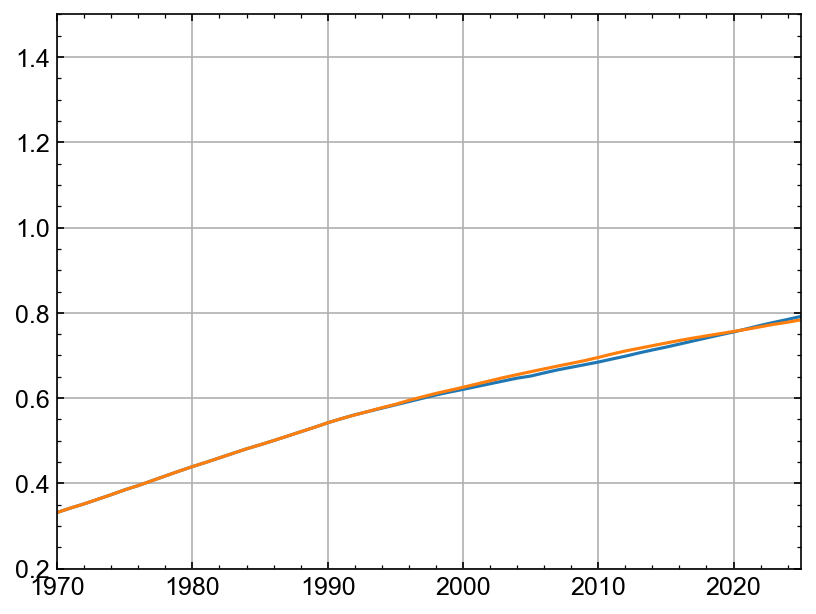

In [89]:
ch4r=((f_noco2.temperature.sel(layer=0, scenario='ssp245-noCO2')) - 
        (f_noco2.temperature.sel(layer=0, scenario='ssp245-noGHG'))).median(dim='config')
ch4r_1990=((f_noco2_1990.temperature.sel(layer=0, scenario='ssp245-noCO2')) - 
        (f_noco2_1990.temperature.sel(layer=0, scenario='ssp245-noGHG'))).median(dim='config')
ch4f=((f_noco2.forcing_sum.sel(scenario='ssp245-noCO2')) - 
        (f_noco2.forcing_sum.sel(scenario='ssp245-noGHG'))).median(dim='config')
ch4f_1990=((f_noco2_1990.forcing_sum.sel(scenario='ssp245-noCO2')) - 
        (f_noco2_1990.forcing_sum.sel(scenario='ssp245-noGHG'))).median(dim='config')
pl.plot(
    f_noco2.timebounds,
    ch4r
)
pl.plot(
    f_noco2.timebounds,
    ch4r_1990
)
pl.ylim(0.2,1.5)
pl.xlim(1970,2025)

pl.grid()

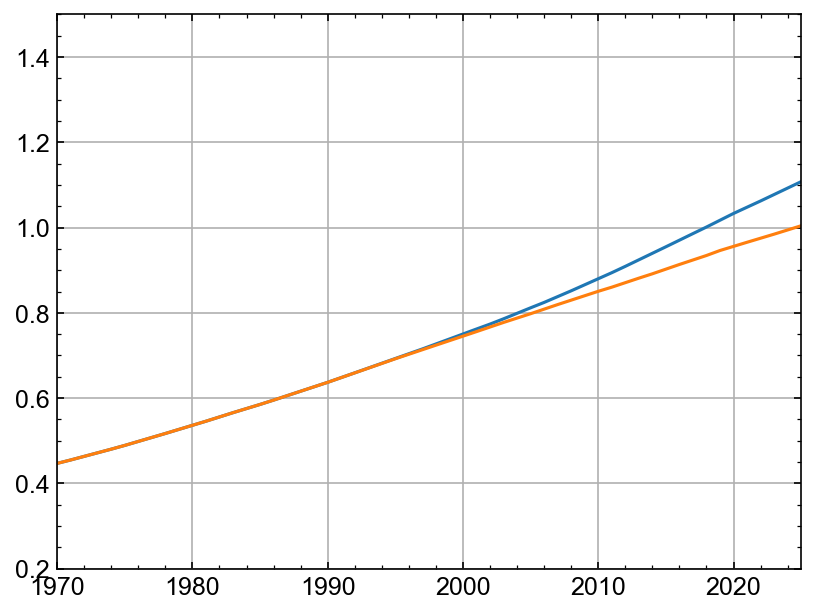

In [87]:
co2r=((f_noco2.temperature.sel(layer=0, scenario='ssp245')) - 
        (f_noco2.temperature.sel(layer=0, scenario='ssp245-noCO2'))).median(dim='config')

co2r_1990=((f_noco2_1990.temperature.sel(layer=0, scenario='ssp245')) - 
        (f_noco2_1990.temperature.sel(layer=0, scenario='ssp245-noCO2'))).median(dim='config')
co2f=((f_noco2.forcing_sum.sel(scenario='ssp245')) - 
        (f_noco2.forcing_sum.sel(scenario='ssp245-noCO2'))).median(dim='config')

co2f_1990=((f_noco2_1990.forcing_sum.sel(scenario='ssp245')) - 
        (f_noco2_1990.forcing_sum.sel(scenario='ssp245-noCO2'))).median(dim='config')



pl.plot(
    f_noco2.timebounds,
    co2r
)
pl.plot(
    f_noco2.timebounds,
    co2r_1990
)
pl.ylim(0.2,1.5)
pl.xlim(1970,2025)

pl.grid()

Text(0, 0.5, 'K')

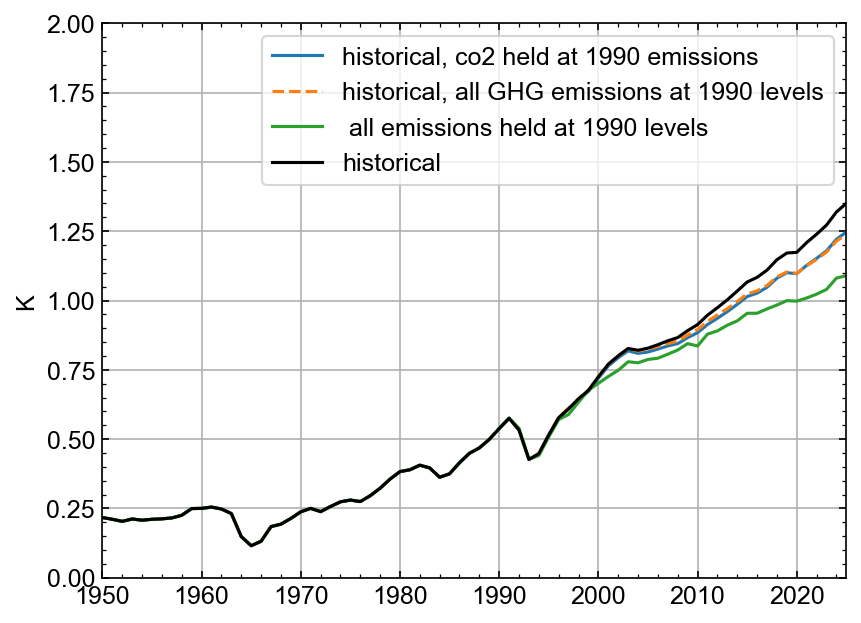

In [94]:
tall=f_noco2.temperature.sel(layer=0, scenario='ssp245').median(dim='config')
dco2=(co2r-co2r_1990)
daer=(nghgr-nghgr_1990)
dch4=(ch4r-ch4r_1990)


t1850=tall.sel(timebounds=[1850,1900]).mean()

pl.plot(
    f_noco2.timebounds,tall-(co2r-co2r_1990)-t1850,label='historical, co2 held at 1990 emissions'
)

pl.plot(
    f_noco2.timebounds,tall-(co2r-co2r_1990)-(ch4r-ch4r_1990)-t1850,label='historical, all GHG emissions at 1990 levels',linestyle='--'
)
pl.plot(
    f_noco2.timebounds,tall-(co2r-co2r_1990)-(ch4r-ch4r_1990)-(nghgr-nghgr_1990)-t1850,label=' all emissions held at 1990 levels'
    )
pl.plot(
    f_noco2.timebounds,tall-t1850,label='historical',color='k'
)
pl.xlim(1950,2025)
pl.ylim(0,2)
pl.grid()
pl.legend()
pl.ylabel('K')


Text(0, 0.5, 'Wm-2')

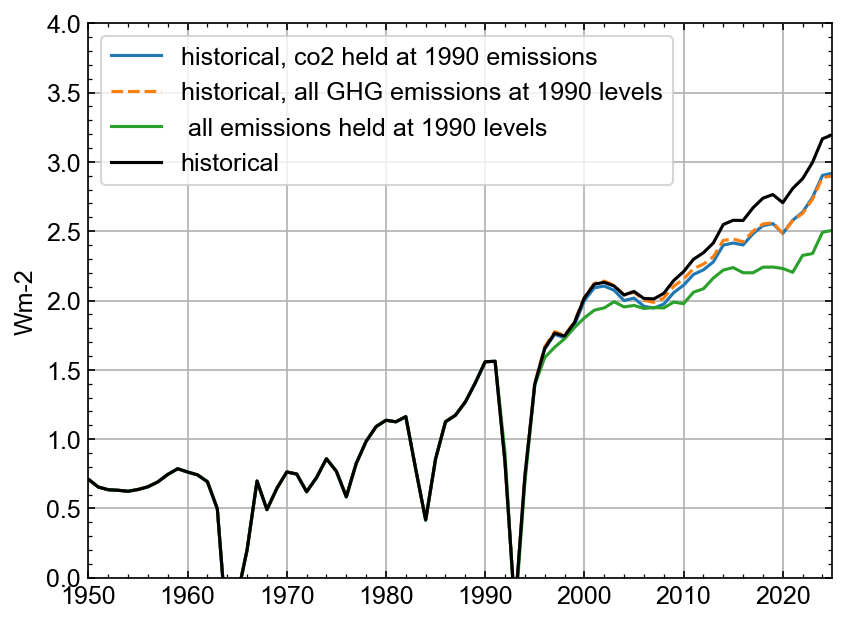

In [93]:
fall=f_noco2.forcing_sum.sel(scenario='ssp245').median(dim='config')
dfco2=(co2f-co2f_1990)
dfaer=(nghgf-nghgf_1990)
dfch4=(ch4f-ch4f_1990)


t1850=tall.sel(timebounds=[1850,1900]).mean()

pl.plot(
    f_noco2.timebounds,fall-dfco2,label='historical, co2 held at 1990 emissions'
)

pl.plot(
    f_noco2.timebounds,fall-dfco2-dfch4,label='historical, all GHG emissions at 1990 levels',linestyle='--'
)
pl.plot(
    f_noco2.timebounds,fall-dfco2-dfch4-dfaer,label=' all emissions held at 1990 levels'
    )
pl.plot(
    f_noco2.timebounds,fall,label='historical',color='k'
)
pl.xlim(1950,2025)
pl.ylim(0,4)
pl.grid()
pl.legend()
pl.ylabel('Wm-2')

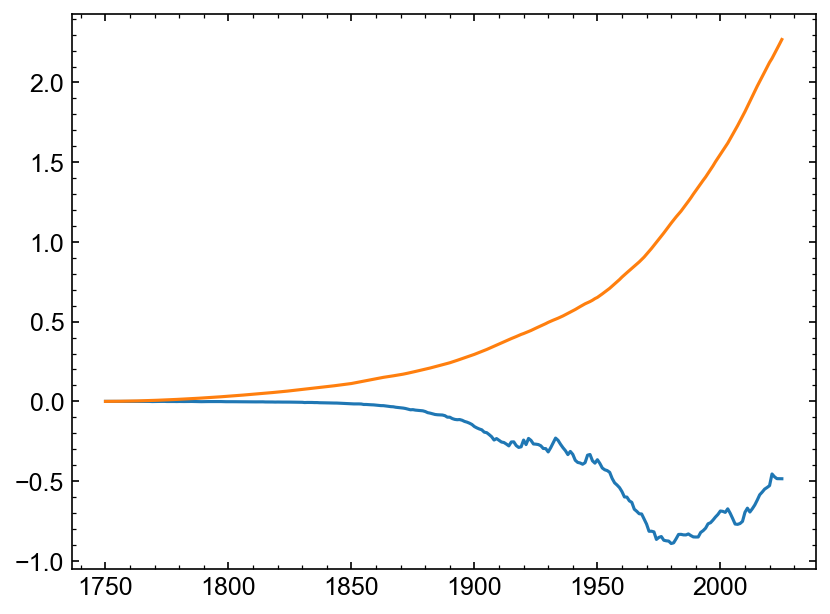

In [103]:
pl.plot(
    f.timebounds,
    (
        (f.forcing_sum.sel(scenario='ssp245')) - 
        (f.forcing_sum.sel(scenario='ssp245-noSO2'))
    ).median(dim='config')
)

pl.plot(
    f.timebounds,
    (
        (f_noco2.forcing_sum.sel(scenario='ssp245')) - 
        (f_noco2.forcing_sum.sel(scenario='ssp245-noCO2'))
    ).median(dim='config')
)

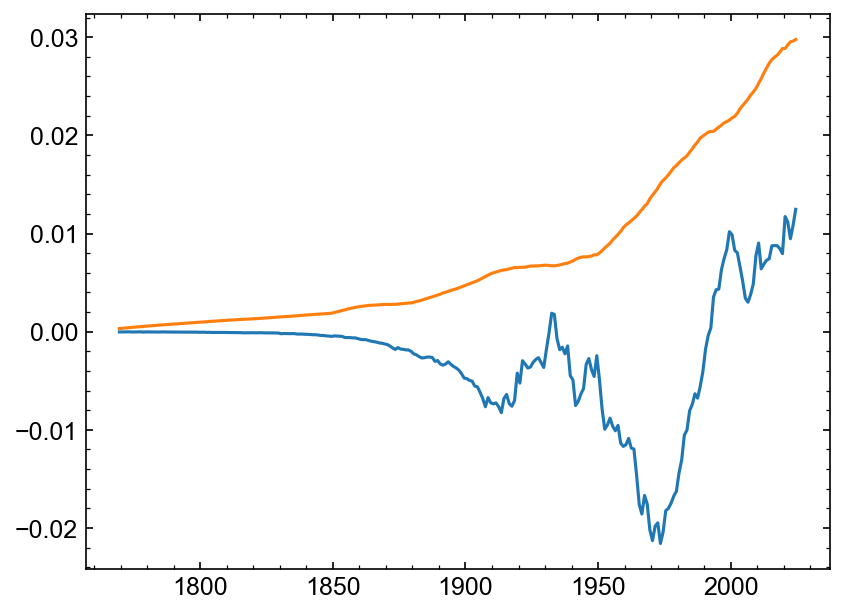

In [102]:
pl.plot(
    f.timepoints,
    (
        (f.forcing_sum.sel(scenario='ssp245')) - 
        (f.forcing_sum.sel(scenario='ssp245-noSO2'))
    ).median(dim='config').diff(dim='timebounds').rolling({'timebounds':20}).mean()
)

pl.plot(
    f.timepoints,
    (
        (f_noco2.forcing_sum.sel(scenario='ssp245')) - 
        (f_noco2.forcing_sum.sel(scenario='ssp245-noCO2'))
    ).median(dim='config').diff(dim='timebounds').rolling({'timebounds':20}).mean()
)

In [ ]:
ce=f_noco2.cumulative_emissions.sel(scenario='ssp245',specie=['CO2 FFI','CO2 AFOLU']).sum(dim='specie').median(dim='config')

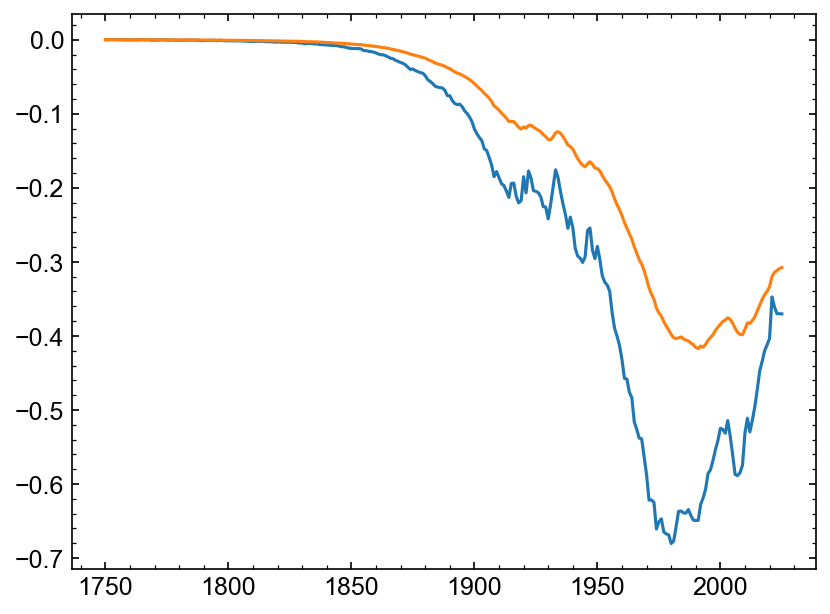

In [82]:
pl.plot(
    f.timebounds,
    (
        (f.forcing_sum.sel(scenario='ssp245')) - 
        (f.forcing_sum.sel(scenario='ssp245-noSO2'))
    ).median(dim='config')/1.31
)
pl.plot(
    f.timebounds,
    (
        (f.temperature.sel(layer=0, scenario='ssp245')) - 
        (f.temperature.sel(layer=0, scenario='ssp245-noSO2'))
    ).median(dim='config')
)

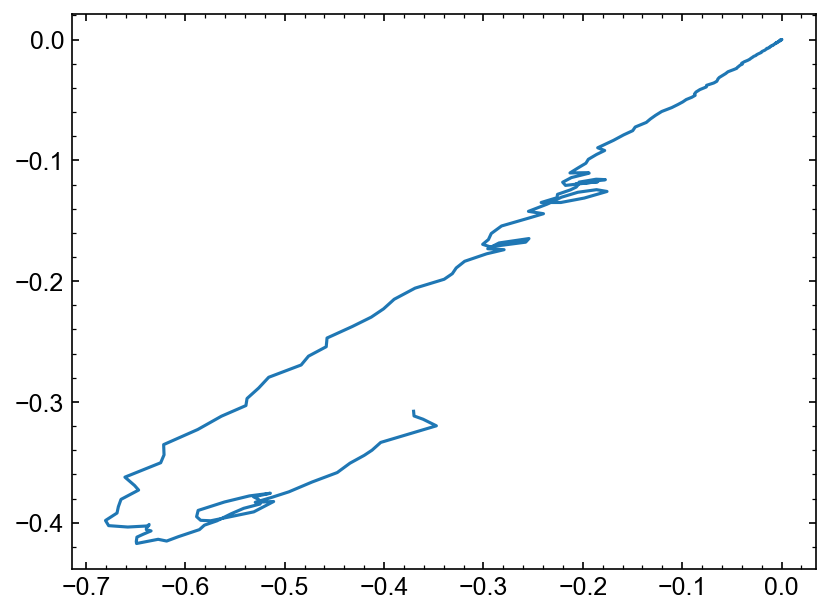

In [ ]:
pl.plot(
    (
        (f.forcing_sum.sel(scenario='ssp245')) - 
        (f.forcing_sum.sel(scenario='ssp245-noSO2'))
    ).median(dim='config')/1.31,
    (
        (f.temperature.sel(layer=0, scenario='ssp245')) - 
        (f.temperature.sel(layer=0, scenario='ssp245-noSO2'))
    ).median(dim='config')
)

(0.0, 3.0)

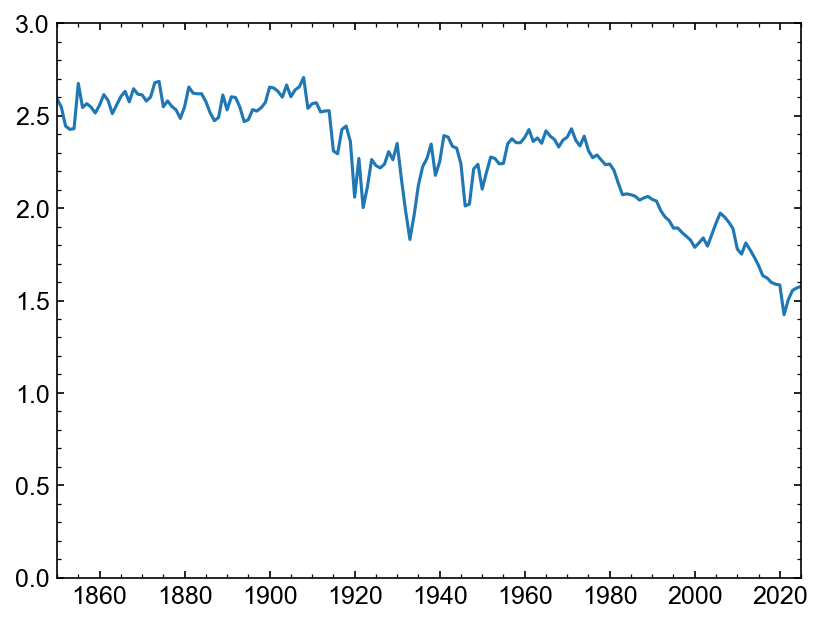

In [ ]:
pl.plot(
    f.timebounds,
    (
        (f.forcing_sum.sel(scenario='ssp245')) - 
        (f.forcing_sum.sel(scenario='ssp245-noSO2'))
    ).median(dim='config')/(
        (f.temperature.sel(layer=0, scenario='ssp245')) - 
        (f.temperature.sel(layer=0, scenario='ssp245-noSO2'))
    ).median(dim='config')
)
pl.xlim(1850, 2025)
pl.ylim(0, 3)

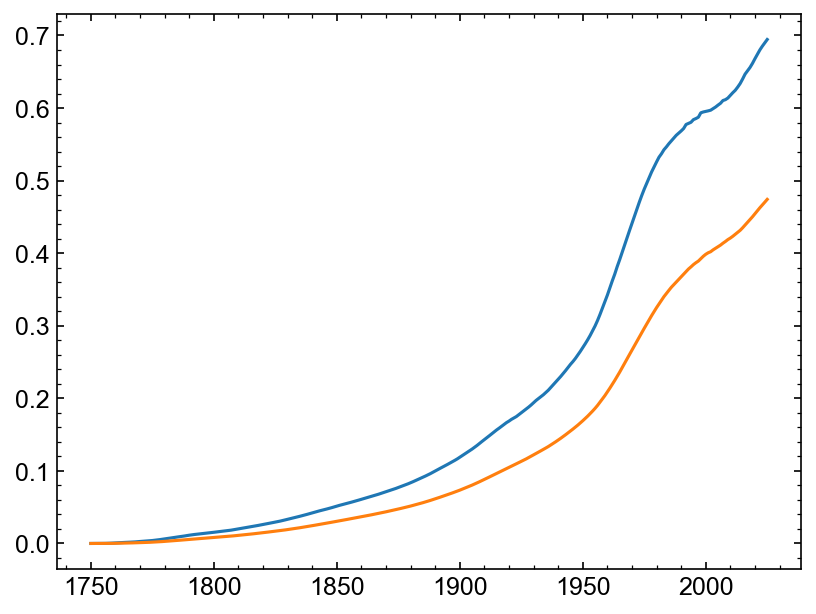

In [ ]:
pl.plot(
    f.timebounds,
    (
        (f.forcing_sum.sel(scenario='ssp245')) - 
        (f.forcing_sum.sel(scenario='ssp245-noCH4'))
    ).median(dim='config')/1.31
)
pl.plot(
    f.timebounds,
    (
        (f.temperature.sel(layer=0, scenario='ssp245')) - 
        (f.temperature.sel(layer=0, scenario='ssp245-noCH4'))
    ).median(dim='config')
)

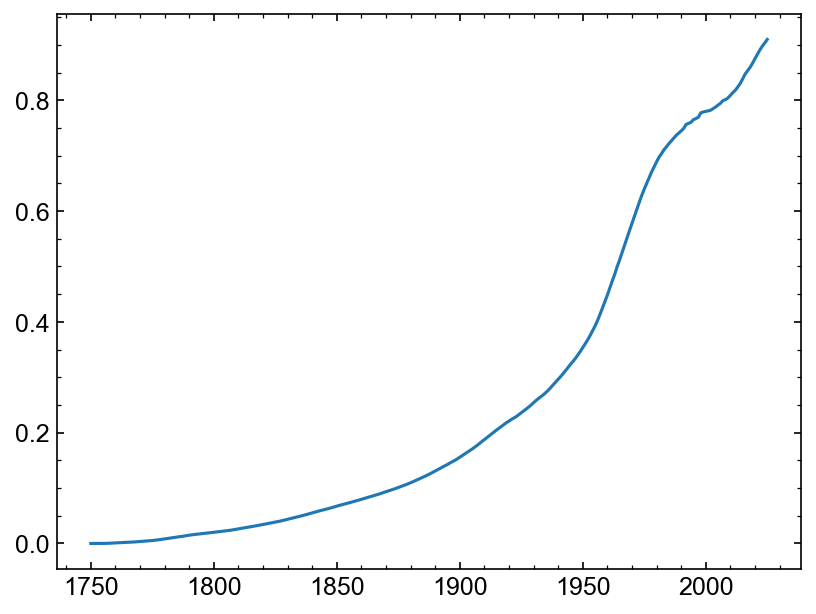

In [ ]:
pl.plot(
    f.timebounds,
    (
        (f.forcing_sum.sel(scenario='ssp245')) - 
        (f.forcing_sum.sel(scenario='ssp245-noCH4'))
    ).median(dim='config')
)

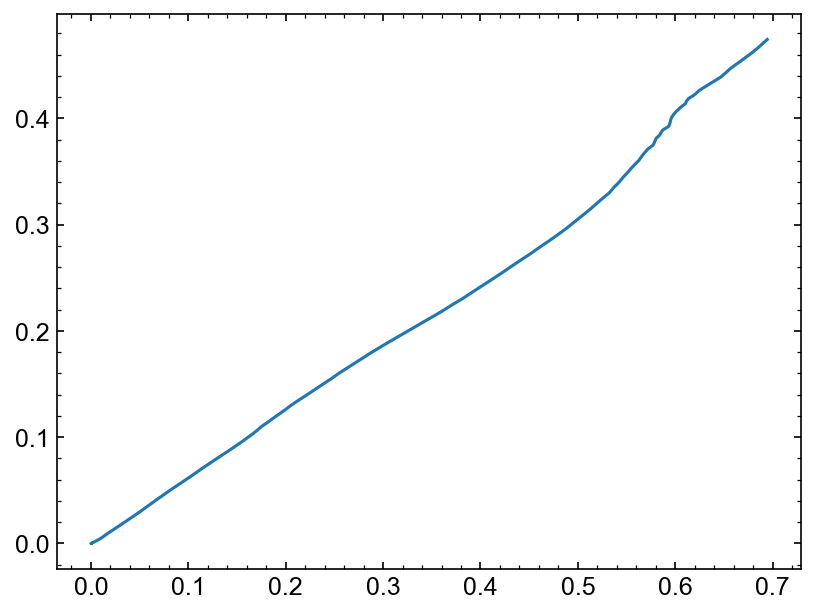

In [ ]:
pl.plot(
    (
        (f.forcing_sum.sel(scenario='ssp245')) - 
        (f.forcing_sum.sel(scenario='ssp245-noCH4'))
    ).median(dim='config')/1.31,
    (
        (f.temperature.sel(layer=0, scenario='ssp245')) - 
        (f.temperature.sel(layer=0, scenario='ssp245-noCH4'))
    ).median(dim='config')
)

(0.0, 3.0)

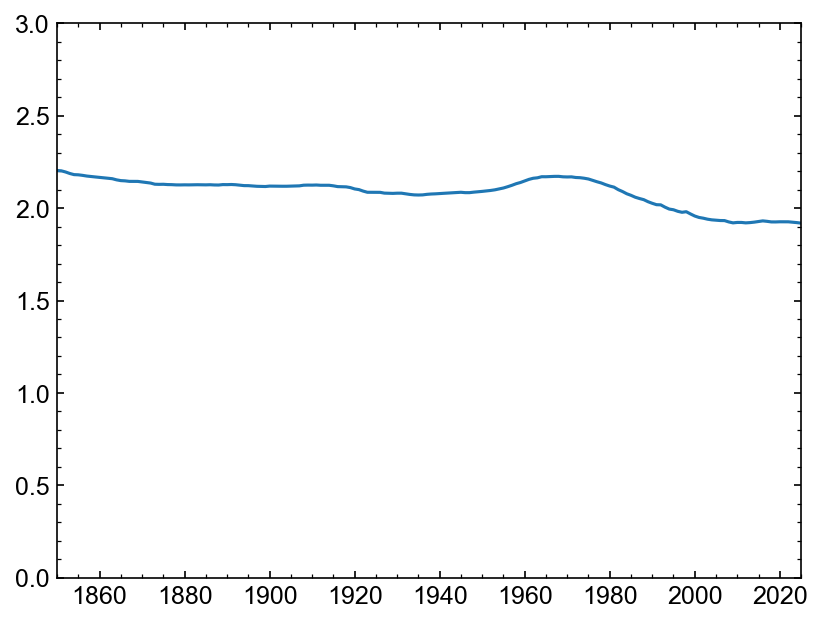

In [ ]:
pl.plot(
    f.timebounds,
    (
        (f.forcing_sum.sel(scenario='ssp245')) - 
        (f.forcing_sum.sel(scenario='ssp245-noCH4'))
    ).median(dim='config')/(
        (f.temperature.sel(layer=0, scenario='ssp245')) - 
        (f.temperature.sel(layer=0, scenario='ssp245-noCH4'))
    ).median(dim='config')
)

pl.xlim(1850, 2025)
pl.ylim(0,3)

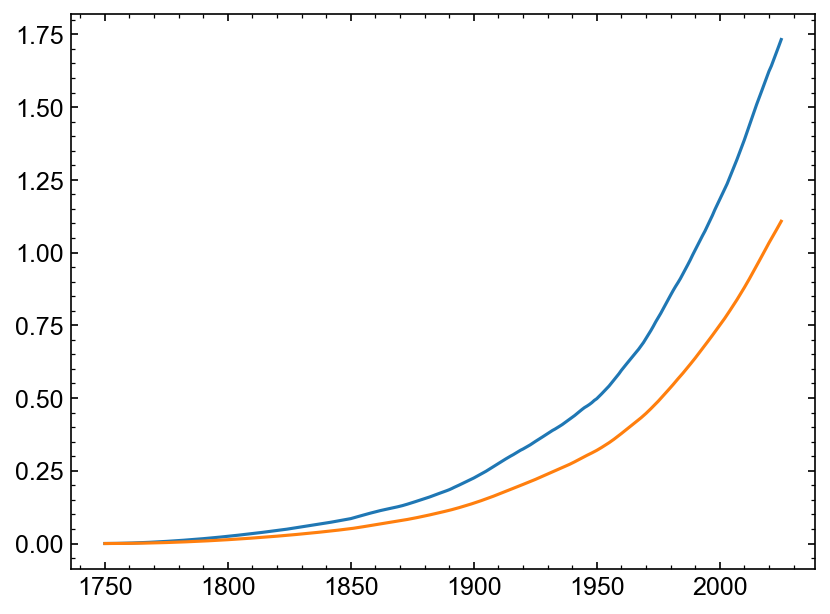

In [ ]:
pl.plot(
    f_noco2.timebounds,
    (
        (f_noco2.forcing_sum.sel(scenario='ssp245')) - 
        (f_noco2.forcing_sum.sel(scenario='ssp245-noCO2'))
    ).median(dim='config')/1.31
)
pl.plot(
    f_noco2.timebounds,
    (
        (f_noco2.temperature.sel(layer=0, scenario='ssp245')) - 
        (f_noco2.temperature.sel(layer=0, scenario='ssp245-noCO2'))
    ).median(dim='config')
)

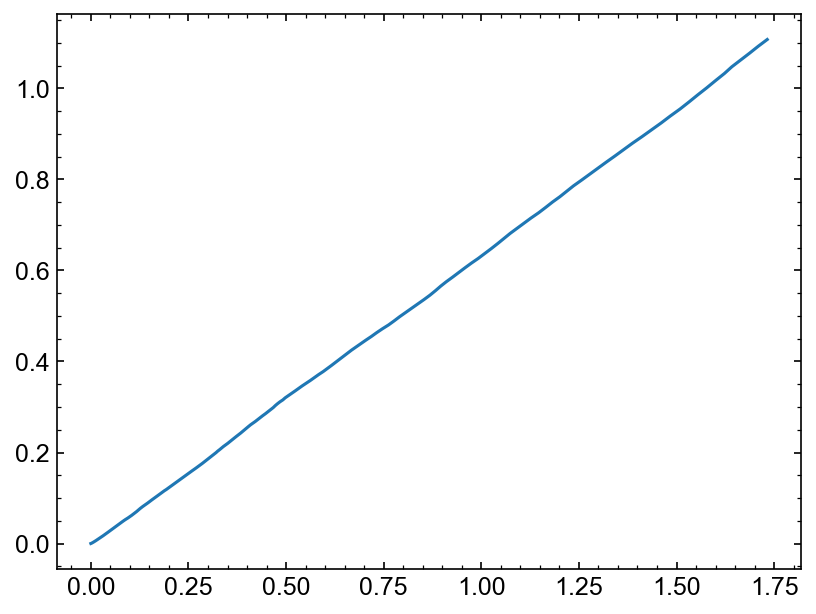

In [ ]:
pl.plot(
    (
        (f_noco2.forcing_sum.sel(scenario='ssp245')) - 
        (f_noco2.forcing_sum.sel(scenario='ssp245-noCO2'))
    ).median(dim='config')/1.31,
    (
        (f_noco2.temperature.sel(layer=0, scenario='ssp245')) - 
        (f_noco2.temperature.sel(layer=0, scenario='ssp245-noCO2'))
    ).median(dim='config')
)

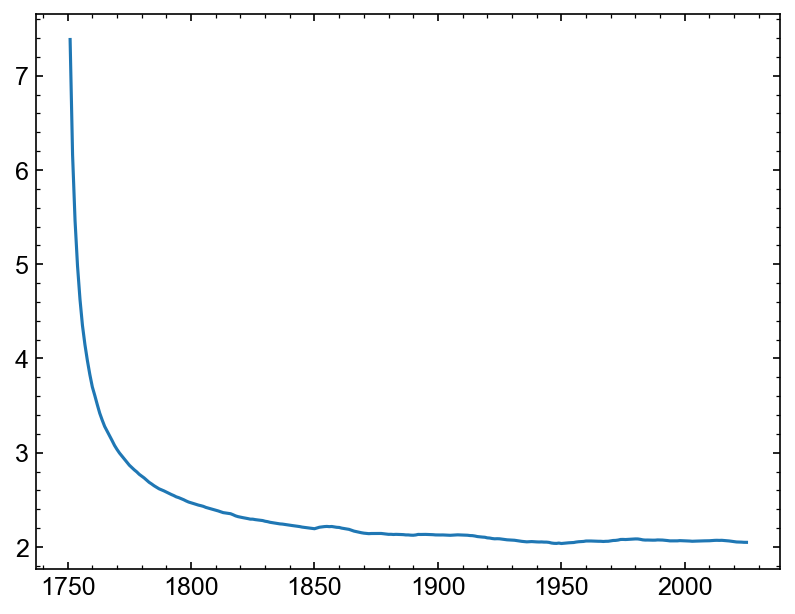

In [ ]:
pl.plot(
    f.timebounds,
    (
        (f_noco2.forcing_sum.sel(scenario='ssp245')) - 
        (f_noco2.forcing_sum.sel(scenario='ssp245-noCO2'))
    ).median(dim='config')/(
        (f_noco2.temperature.sel(layer=0, scenario='ssp245')) - 
        (f_noco2.temperature.sel(layer=0, scenario='ssp245-noCO2'))
    ).median(dim='config')
)

In [ ]:
data = np.array(
    [
        (
            (f.temperature.sel(layer=0, scenario='ssp245')) - 
            (f.temperature.sel(layer=0, scenario='ssp245-noCH4'))
        ).quantile(0.05, dim='config'),
        (
            (f.temperature.sel(layer=0, scenario='ssp245')) - 
            (f.temperature.sel(layer=0, scenario='ssp245-noCH4'))
        ).median(dim='config'),
        (
            (f.temperature.sel(layer=0, scenario='ssp245')) - 
            (f.temperature.sel(layer=0, scenario='ssp245-noCH4'))
        ).quantile(0.95, dim='config')
    ]
)
data = (data[:, :-1] + data[:, 1:])/2
data

array([[ 0.00000000e+00, -3.75457237e-06, -1.32870150e-05,
        -2.08450199e-05, -1.55817280e-05,  5.43637577e-07,
         2.01266901e-05,  4.80734984e-05,  8.67154769e-05,
         1.32337103e-04,  1.86306719e-04,  2.48093897e-04,
         3.12460342e-04,  3.76850787e-04,  4.35531953e-04,
         4.94304008e-04,  5.61241045e-04,  6.31851908e-04,
         7.14712755e-04,  8.08075192e-04,  9.00167880e-04,
         9.91159468e-04,  1.08044828e-03,  1.17282240e-03,
         1.28414910e-03,  1.41517966e-03,  1.55266325e-03,
         1.69976468e-03,  1.86472069e-03,  2.04117984e-03,
         2.22993744e-03,  2.43105174e-03,  2.63153150e-03,
         2.82832261e-03,  3.02090658e-03,  3.21612346e-03,
         3.41597415e-03,  3.61810884e-03,  3.83586273e-03,
         4.06421977e-03,  4.28858432e-03,  4.50448713e-03,
         4.71269766e-03,  4.91463912e-03,  5.11873082e-03,
         5.32392113e-03,  5.51550901e-03,  5.69830747e-03,
         5.88420621e-03,  6.07667752e-03,  6.26790995e-0

In [ ]:
df_ch4 = pd.DataFrame(data.T, columns=['p5', 'median', 'p95'], index=f.timepoints)
os.makedirs('../output', exist_ok=True)
df_ch4.to_csv('../output/ch4_emissions_attribution.csv')

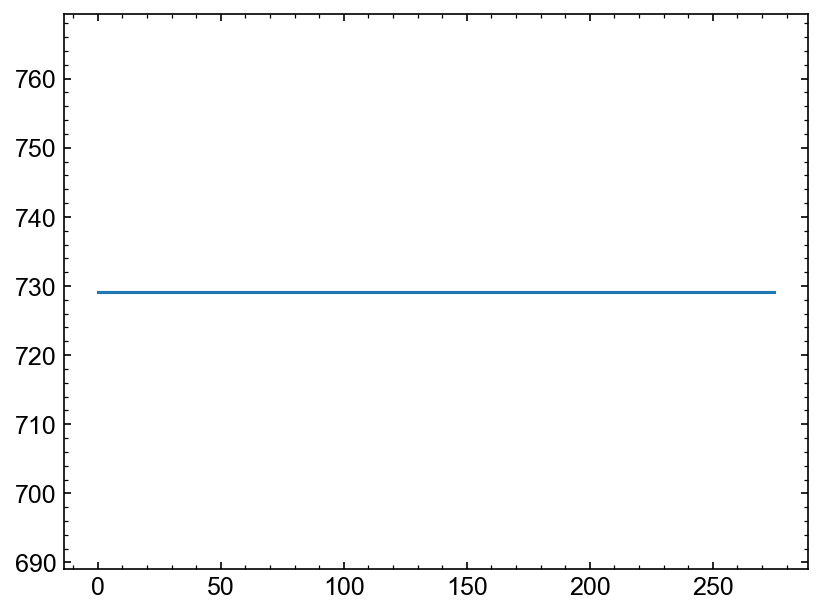

In [ ]:
pl.plot(f.concentration.sel(scenario='ssp245-noCH4', specie='CH4').median(dim='config'))

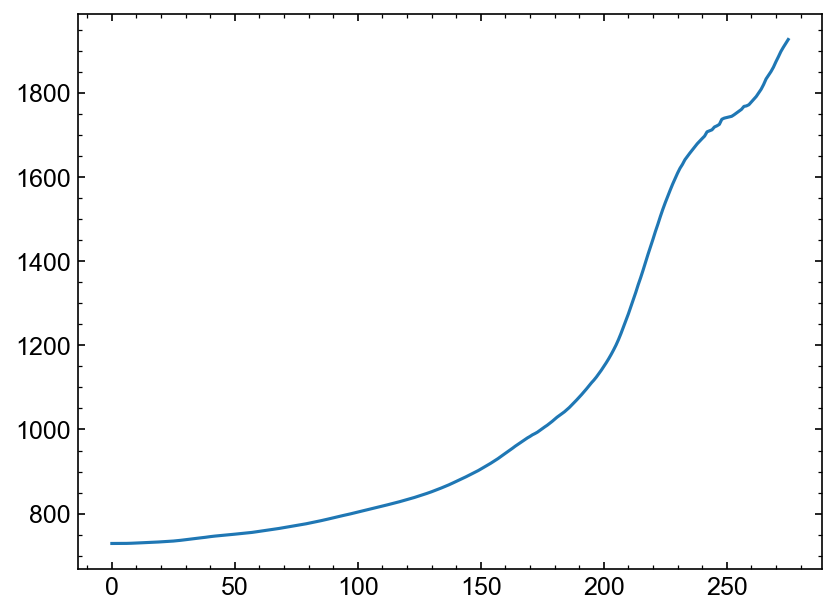

In [ ]:
pl.plot(f.concentration.sel(scenario='ssp245', specie='CH4').median(dim='config'))